In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

Mounted at /content/gdrive


In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import json
import os
import pickle
from matplotlib import pyplot as plt

In [187]:
directory_name = "gdrive/MyDrive/Colab Notebooks/GESTALT/COMPASS/data/experiments"
experiments_list = next(os.walk(directory_name))[1]
experiments_list = [x for x in experiments_list if "dist" not in x]  # take only the dilated, translated, rotated queries

CONSTRUCT DICTS WITH INFO NEEDED FOR RESULTS TABLES

In [188]:
obj_obj_data = {}  # maps experiment name that can be looked up in MD file to the data filename
card_inv_data = {}  # maps experiment name that can be looked up in MD file to the data filename
md_mapping = {}  # maps experiment name to corresponding MD file

for i in range(len(experiments_list)):
  all_pickles = glob.glob(os.path.join(directory_name, experiments_list[i], "*.pkl"))
  metadata_file = glob.glob(os.path.join(directory_name, experiments_list[i], "*.json"))
  try:
    obj_obj_file = [x for x in all_pickles if "cardinality" not in x][0]
    exp_name = obj_obj_file.split(directory_name+"/")[1].split("/")[0]
    obj_obj_data[exp_name] = obj_obj_file
    md_mapping[exp_name] = metadata_file[0]
  except IndexError:  # means we dont have this experiment
    pass
  try:
    card_inv_file = [x for x in all_pickles if "cardinality" in x][0]
    exp_name = card_inv_file.split(directory_name+"/")[1].split("/")[0]
    card_inv_data[exp_name] = card_inv_file
    md_mapping[exp_name] = metadata_file[0]
  except IndexError:  # means we dont have this experiment
    pass

In [189]:
obj_obj_querysize_exp_info = {}  # maps experiment name to num queries
card_inv_querysize_exp_info = {}  # maps experiment name to num queries

for key in obj_obj_data.keys():
  with open(md_mapping[key]) as f:
    qs = json.load(f)["queries"]["query"]
    for query in qs:
      obj_obj_querysize_exp_info[key] = qs[query]['num_query_terms']  # populate with num query terms, same across all 5

for key in card_inv_data.keys():
  with open(md_mapping[key]) as f:
    qs = json.load(f)["queries"]["query"]
    for query in qs:
      card_inv_querysize_exp_info[key] = qs[query]['num_query_terms']  # populate with num query terms, same across all 5

In [190]:
obj_obj_objsize_exp_info = {}  # maps experiment name to num objs per loc
card_inv_objsize_exp_info = {}  # maps experiment name to num objs per loc

for key in obj_obj_data.keys():
  with open(md_mapping[key]) as f:
    locs = json.load(f)["locations"]["location"]
    for loc in locs:
      # take an average... accumulate all 10 then divide by 10 after
      if key in obj_obj_objsize_exp_info:
        obj_obj_objsize_exp_info[key] = obj_obj_objsize_exp_info[key] + locs[loc]['num_objects']
      else:
        obj_obj_objsize_exp_info[key] = locs[loc]['num_objects']
  obj_obj_objsize_exp_info[key] = obj_obj_objsize_exp_info[key] / 10  # now we have an average


for key in card_inv_data.keys():
  with open(md_mapping[key]) as f:
    locs = json.load(f)["locations"]["location"]
    for loc in locs:
      # take an average... accumulate all 10 then divide by 10 after
      if key in card_inv_objsize_exp_info:
        card_inv_objsize_exp_info[key] = card_inv_objsize_exp_info[key] + locs[loc]['num_objects']
      else:
        card_inv_objsize_exp_info[key] = locs[loc]['num_objects']
  card_inv_objsize_exp_info[key] = card_inv_objsize_exp_info[key] / 10  # now we have an average

In [191]:
obj_obj_time_exp_info = {}  # maps experiment name to average time
card_inv_time_exp_info = {}  # maps experiment name to average time

obj_obj_acc_exp_info = {}  # maps experiment name to confusion matrix info
card_inv_acc_exp_info = {}  # maps experiment name to confusion matrix info

for key in md_mapping:
  try:
    with open(obj_obj_data[key], 'rb') as f:
      data_dict = pickle.load(f)
      for subkey in data_dict.keys():
        if subkey == 'times':
          obj_obj_time_exp_info[key] = (data_dict[subkey]['overall']['end  '] - data_dict[subkey]['overall']['start']).total_seconds()/5  # average time over 5 queries of exp size, in form H:MM:SS:MS
        if subkey == 'results':
          TP, FP, TN, FN = 0, 0, 0, 0
          for qkey in data_dict[subkey]['queries']:
            TP += data_dict[subkey]['queries'][qkey]['TP']
            FP += data_dict[subkey]['queries'][qkey]['FP']
            TN += data_dict[subkey]['queries'][qkey]['TN']
            FN += data_dict[subkey]['queries'][qkey]['FN']
          obj_obj_acc_exp_info[key] = {"TP":TP, "FP":FP, "TN":TN, "FN":FN}
  except KeyError:  # means we dont have info for this experiment
    pass

for key in md_mapping:
  try:
    with open(card_inv_data[key], 'rb') as f:
      data_dict = pickle.load(f)
      for subkey in data_dict.keys():
        if subkey == 'times':
          card_inv_time_exp_info[key] = (data_dict[subkey]['overall']['end  '] - data_dict[subkey]['overall']['start']).total_seconds()/5  # average time over 5 queries of exp size, in form H:MM:SS:MS
          print(key, card_inv_time_exp_info[key])
        if subkey == 'results':
          TP, FP, TN, FN = 0, 0, 0, 0
          for qkey in data_dict[subkey]['queries']:
            TP += data_dict[subkey]['queries'][qkey]['TP']
            FP += data_dict[subkey]['queries'][qkey]['FP']
            TN += data_dict[subkey]['queries'][qkey]['TN']
            FN += data_dict[subkey]['queries'][qkey]['FN']
          card_inv_acc_exp_info[key] = {"TP":TP, "FP":FP, "TN":TN, "FN":FN}
  except KeyError:  # means we dont have info for this experiment
    pass


obj10_que10 0.5711862
obj1024_que32 115.5252984
obj512_que4 2.7589254
obj64_que64 62.5255448
obj512_que512 2830.6620396
obj10_que100 158.8293198
obj128_que16 3.4843534
obj1024_que8 25.287540999999997
obj10_que4 0.23518080000000002
obj16_que16 2.7481356000000003
obj32_que16 2.8115128
obj256_que32 19.3100766
obj1000_que4 10.5112242
obj1000_que100 391.270615
obj128_que32 14.9049452
obj64_que8 0.8336658
obj256_que128 292.723568
obj256_que16 5.843128200000001
obj32_que32 13.104125
obj128_que128 281.18190500000003
obj16_que4 0.237631
obj1024_que16 53.967030199999996
obj512_que64 105.29163779999999
obj4_que4 0.2259722
obj256_que4 0.8443896000000001
obj256_que256 973.0639744
obj128_que4 0.3918796
obj32_que8 0.758615
obj1000_que10 31.5922924
obj64_que32 13.5318386
obj512_que128 346.4965592
obj512_que8 6.6952436
obj1024_que64 233.93158079999998
obj512_que16 15.484454
obj256_que64 73.4903596
obj100_que100 163.7367074
obj512_que256 1053.732315
obj1024_que4 10.3660856
obj1024_que128 554.881016
obj1

MAKE RESULTS TABLE

obj_obj_querysize_exp_info  # maps experiment name to num queries
card_inv_query_exp_info  # maps experiment name to num queries

obj_obj_objsize_exp_info  # maps experiment name to num objs per loc
card_inv_objsize_exp_info  # maps experiment name to num objs per loc

obj_obj_time_exp_info  # maps experiment name to average time
card_inv_time_exp_info  # maps experiment name to average time

obj_obj_acc_exp_info  # maps experiment name to confusion matrix info
card_inv_acc_exp_info  # maps experiment name to confusion matrix info

In [192]:
def calc_num_constraints(num_query_pts: int):
  accumulator = 0
  for i in range(num_query_pts - 1, 0, -1):
    accumulator += i
  return accumulator

In [193]:
rows = []
for i, key in enumerate(obj_obj_acc_exp_info.keys()):
  query_size = obj_obj_querysize_exp_info[key]
  num_constraints = calc_num_constraints(query_size)
  avg_num_objs = obj_obj_objsize_exp_info[key]
  time = obj_obj_time_exp_info[key]

  # row precision and recall
  acc_dict = obj_obj_acc_exp_info[key]
  prec = (acc_dict['TP']) / (acc_dict['TP'] + acc_dict['FP'])
  recall = (acc_dict['TP']) / (acc_dict['TP'] + acc_dict['FN'])

  row = [query_size, num_constraints, avg_num_objs, prec, recall, time]

  rows.append(row)

obj_obj_results_df = pd.DataFrame(rows, columns = ["query_size", "num_constraints", "avg_num_objs_per_loc", "precision", "recall", "avg_time_(s)_over_5_queries"])

In [194]:
rows = []
for i, key in enumerate(card_inv_acc_exp_info.keys()):
  query_size = card_inv_querysize_exp_info[key]
  num_constraints = calc_num_constraints(query_size)
  avg_num_objs = card_inv_objsize_exp_info[key]
  time = card_inv_time_exp_info[key]

  # row precision and recall
  acc_dict = card_inv_acc_exp_info[key]
  prec = (acc_dict['TP']) / (acc_dict['TP'] + acc_dict['FP'])
  recall = (acc_dict['TP']) / (acc_dict['TP'] + acc_dict['FN'])

  row = [query_size, num_constraints, avg_num_objs, prec, recall, time]

  rows.append(row)

card_inv_results_df = pd.DataFrame(rows, columns = ["query_size", "num_constraints", "avg_num_objs_per_loc", "precision", "recall", "avg_time_(s)_over_5_queries"])

In [195]:
# FULL CARD INV TABLE
card_inv_results_df.sort_values(by=['query_size', 'num_constraints', 'avg_num_objs_per_loc'])

,query_size,num_constraints,avg_num_objs_per_loc,precision,recall,avg_time_(s)_over_5_queries
23,4,6,8.8,0.714286,1.0,0.225972
8,4,6,15.6,0.714286,1.0,0.235181
20,4,6,16.6,0.714286,1.0,0.237631
41,4,6,32.5,0.714286,1.0,0.236068
42,4,6,64.3,0.714286,1.0,0.261269
49,4,6,125.9,0.714286,1.0,0.362158
26,4,6,126.9,0.714286,1.0,0.391880
24,4,6,254.8,0.714286,1.0,0.844390
2,4,6,510.2,0.714286,1.0,2.758925
12,4,6,1016.6,0.714286,1.0,10.511224


In [196]:
# CARD INV BY DB SIZE AND QUERY SIZE
display(card_inv_results_df.groupby(['query_size', 'num_constraints']).agg({'avg_time_(s)_over_5_queries':'mean'}))
display(card_inv_results_df.groupby(['avg_num_objs_per_loc']).agg({'avg_time_(s)_over_5_queries':'mean'}))

display(card_inv_results_df.groupby(['query_size', 'num_constraints']).agg({'precision':'mean', 'recall':'mean'}))
display(card_inv_results_df.groupby(['avg_num_objs_per_loc']).agg({'precision':'mean', 'recall':'mean'}))

,,avg_time_(s)_over_5_queries
query_size,num_constraints,
4,6,2.402798
8,28,4.796224
10,45,1031.228187
16,120,12.475605
32,496,35.782737
64,2016,108.016043
100,4950,237.945547
128,8128,368.820762
256,32640,1013.398145


,avg_time_(s)_over_5_queries
avg_num_objs_per_loc,
8.8,0.225972
10.7,0.724233
15.6,0.235181
16.6,0.237631
18.3,0.571186
18.9,0.741812
22.9,2.748136
32.5,0.236068
34.1,0.758615


,,precision,recall
query_size,num_constraints,,
4,6,0.714286,1.0
8,28,0.833333,1.0
10,45,1.000000,1.0
16,120,1.000000,1.0
32,496,1.000000,1.0
64,2016,1.000000,1.0
100,4950,1.000000,1.0
128,8128,1.000000,1.0
256,32640,1.000000,1.0


,precision,recall
avg_num_objs_per_loc,,
8.8,0.714286,1.0
10.7,0.833333,1.0
15.6,0.714286,1.0
16.6,0.714286,1.0
18.3,1.000000,1.0
18.9,0.833333,1.0
22.9,1.000000,1.0
32.5,0.714286,1.0
34.1,0.833333,1.0


In [177]:
# FULL OBJ OBJ TABLE
display(obj_obj_results_df.sort_values(by=['query_size', 'num_constraints', 'avg_num_objs_per_loc']))

,query_size,num_constraints,avg_num_objs_per_loc,precision,recall,avg_time_(s)_over_5_queries
11,4,6,8.2,1.0,0.8,0.029150
39,4,6,16.8,1.0,0.8,0.029802
19,4,6,32.3,1.0,1.0,0.032865
13,4,6,63.7,1.0,1.0,0.043178
5,4,6,127.2,1.0,0.8,0.080207
4,4,6,254.6,1.0,0.8,0.233783
10,4,6,510.3,1.0,1.0,0.849602
26,4,6,1021.9,1.0,1.0,3.379038
33,8,28,10.6,1.0,0.8,0.044338
20,8,28,18.4,1.0,0.8,0.044504


In [185]:
# OBJ OBJ BY DB SIZE AND QUERY SIZE
display(obj_obj_results_df.groupby(['query_size', 'num_constraints']).agg({'avg_time_(s)_over_5_queries':'mean'}))
display(obj_obj_results_df.groupby(['avg_num_objs_per_loc']).agg({'avg_time_(s)_over_5_queries':'mean'}))

display(obj_obj_results_df.groupby(['query_size', 'num_constraints']).agg({'precision':'mean', 'recall':'mean'}))
display(obj_obj_results_df.groupby(['avg_num_objs_per_loc']).agg({'precision':'mean', 'recall':'mean'}))

,,avg_time_(s)_over_5_queries
query_size,num_constraints,
4,6,0.584703
8,28,0.615764
16,120,0.723034
32,496,0.884345
64,2016,1.197245
128,8128,1.402499
256,32640,2.988528
512,130816,4.712934
1024,523776,18.550458


,avg_time_(s)_over_5_queries
avg_num_objs_per_loc,
8.2,0.029150
10.6,0.044338
16.8,0.029802
18.4,0.044504
21.5,0.057193
32.3,0.032865
34.0,0.047518
36.9,0.062415
44.9,0.113110


,,precision,recall
query_size,num_constraints,,
4,6,1.0,0.900000
8,28,1.0,0.800000
16,120,1.0,0.657143
32,496,1.0,0.800000
64,2016,1.0,0.800000
128,8128,1.0,0.200000
256,32640,1.0,0.800000
512,130816,1.0,0.400000
1024,523776,1.0,0.800000


,precision,recall
avg_num_objs_per_loc,,
8.2,1.0,0.8
10.6,1.0,0.8
16.8,1.0,0.8
18.4,1.0,0.8
21.5,1.0,0.6
32.3,1.0,1.0
34.0,1.0,0.8
36.9,1.0,0.4
44.9,1.0,0.8


PLOTS

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

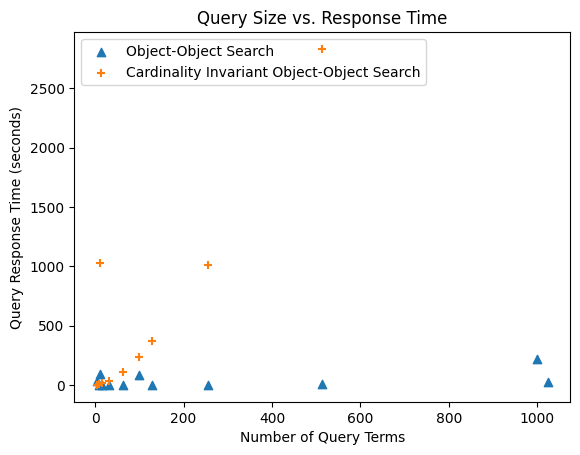

In [227]:
obj_time_data = obj_obj_results_df.groupby(['query_size'], as_index=False).agg({'avg_time_(s)_over_5_queries':'mean'})
card_time_data = card_inv_results_df.groupby(['query_size'], as_index=False).agg({'avg_time_(s)_over_5_queries':'mean'})

plt.scatter(obj_time_data['query_size'], obj_time_data['avg_time_(s)_over_5_queries']	, label = "Object-Object Search", marker='^')
plt.scatter(card_time_data['query_size'], card_time_data['avg_time_(s)_over_5_queries']	, label = "Cardinality Invariant Object-Object Search", marker='+')

plt.title("Query Size vs. Response Time")
plt.xlabel("Number of Query Terms")
plt.ylabel("Query Response Time (seconds)")

plt.legend(loc="upper left", facecolor="None")
plt.savefig("./compassQuerySizeTime.svg")
files.download("compassQuerySizeTime.svg")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

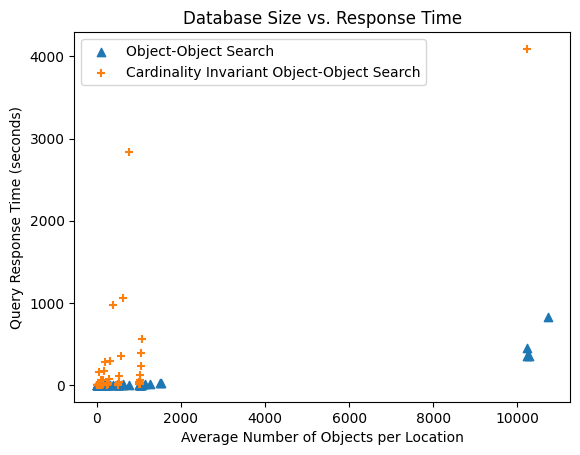

In [226]:
obj_time_data = obj_obj_results_df.groupby(['avg_num_objs_per_loc'], as_index=False).agg({'avg_time_(s)_over_5_queries':'mean'})
card_time_data = card_inv_results_df.groupby(['avg_num_objs_per_loc'], as_index=False).agg({'avg_time_(s)_over_5_queries':'mean'})

plt.scatter(obj_time_data['avg_num_objs_per_loc'], obj_time_data['avg_time_(s)_over_5_queries']	, label = "Object-Object Search", marker='^')
plt.scatter(card_time_data['avg_num_objs_per_loc'], card_time_data['avg_time_(s)_over_5_queries']	, label = "Cardinality Invariant Object-Object Search", marker='+')

plt.title("Database Size vs. Response Time")
plt.xlabel("Average Number of Objects per Location")
plt.ylabel("Query Response Time (seconds)")

plt.legend()
plt.savefig("./compassDbSizeTime.svg")
files.download("compassDbSizeTime.svg")
plt.show()